In [1]:
# Importing dependencies
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

from art.attacks.evasion import AdversarialPatchTensorFlowV2
from art.utils import load_dataset, to_categorical
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
# Loading the dataset
(train_images_original, train_labels_original), (test_images_original, test_labels_original), min, max = load_dataset(name="cifar10")


In [3]:
# Function for creating model
# For the next of the illustrations we will use CNN model

def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(32, 32, 3)),
        Conv2D(filters=32, kernel_size=3, activation="relu", strides=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        Conv2D(filters=64, kernel_size=3, activation="relu", strides=2),
        Flatten(),
        Dense(units=100, activation="relu"),
        Dense(units=10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [4]:
# Training our model to before to demonstrate mechanism
model=create_model()

model.fit(x=train_images_original,y=train_labels_original,epochs=10)





Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 22s 434us/sample - loss: 1.5301 - accuracy: 0.4417
Epoch 2/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.1452 - accuracy: 0.5934
Epoch 3/10
50000/50000 [==============================] - 32s 639us/sample - loss: 0.9748 - accuracy: 0.6550
Epoch 4/10
50000/50000 [==============================] - 20s 392us/sample - loss: 0.8623 - accuracy: 0.6987
Epoch 5/10
50000/50000 [==============================] - 20s 397us/sample - loss: 0.7678 - accuracy: 0.7317
Epoch 6/10
50000/50000 [==============================] - 19s 386us/sample - loss: 0.6958 - accuracy: 0.7553
Epoch 7/10
50000/50000 [==============================] - 20s 393us/sample - loss: 0.6188 - accuracy: 0.7838
Epoch 8/10
50000/50000 [==============================] - 20s 404us/sample - loss: 0.5581 - accuracy: 0.8023
Epoch 9/10
50000/50000 [==============================] - 19s 388us/sample - loss: 0.4952 - accuracy: 0

In [5]:
# Evaluating the performances before adversaries
score = model.evaluate(x=test_images_original, y=test_labels_original)

# Test loss and accuracy
print("TEST METRICS")
print(f"Test loss : {score[0]:.2f} "
      f"vs Test Accuracy: {score[1]:.2f}")


C:\Users\Darshan Mourya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


TEST METRICS
Test loss : 1.13 vs Test Accuracy: 0.67


In [6]:
from art.estimators.classification import KerasClassifier
_classifier=KerasClassifier(
    model=model,
    clip_values=(min,max)
)

In [ ]:
# Creating an instance of the AdversarialPatch attack
from art.attacks.evasion import AdversarialPatch
Patch = AdversarialPatch(
    classifier=_classifier ,
    rotation_max=.5, 
    scale_min=2e-2,
    scale_max=1e-2,
    learning_rate=.05,
    max_iter=250,
    batch_size=16,
    patch_shape=(32,32,3),
    targeted=True,
    verbose=True
)

# There is always trade of between inconspicousness and effectiveness while deciding values of scale_min, scale_max,rotation_max..

In [ ]:

# Generate an adversarial patch
_patch, patch_mask = Patch.generate(x=train_images_original[:100], y=train_labels_original[:100])

# Apply the adversarial patch to new instances
adversarial_instances = Patch.apply_patch(x=test_images_original[:100], scale=1.0, patch_external=_patch)

In [ ]:
# Functions to Display created adversarial examples
def create_figure_axes(
    nrows, 
    ncols, 
    figsize
    ):
    # Creating a figure and axes
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=figsize
        )

    # Returning the figure and axes
    return fig, axes

# Function for plotting images
def plot_images(
    images,
    labels,    
    plot_label,
    is_categorical,
    nrows, 
    ncols,
    figsize
    ):    
    # Creating a figure and axes
    fig, axes = create_figure_axes(
        nrows=nrows, 
        ncols=ncols, 
        figsize=figsize
        )

    # Defining a counting variable
    counter = 0

    # Iterating over our rows and cols,
    # plotting poisoned test images
    # along with their true targets
    for i in range(nrows):
        for j in range(ncols):
            # Converting the current label to an integer 
            # if it is categorical
            if is_categorical:
                label = np.argmax(a=labels[counter])
            else:
                label = labels[counter]
            
            # Displaying the current image
            # and setting axis title
            axes[i, j].imshow(images[counter])
            axes[i, j].set_title(label=f"{plot_label}: {label}")

            # Disabling ticks
            axes[i, j].set_xticks(ticks=[])
            axes[i, j].set_yticks(ticks=[])

            # Incrementing the counter
            counter += 1

In [ ]:
# Evaluating the performances before adversaries
score1 = model.evaluate(x=test_images_original[100:200], y=test_labels_original[100:200])
score2 = model.evaluate(x=adversarial_instances, y=test_labels_original[:100])

# Test losses and accuracy
print("TEST METRICS ON CLEAN IMAGES")
print(f"Test loss : {score1[0]:.2f} "
      f"vs Test Accuracy: {score1[1]:.2f}")

print("TEST METRICS ON ADVERSARIAL IMAGES")
print(f"Test loss : {score2[0]:.2f} "
      f"vs Test Accuracy: {score2[1]:.2f}")


TEST METRICS ON CLEAN IMAGES
Test loss : 1.10 vs Test Accuracy: 0.72
TEST METRICS ON ADVERSARIAL IMAGES
Test loss : 4.16 vs Test Accuracy: 0.08


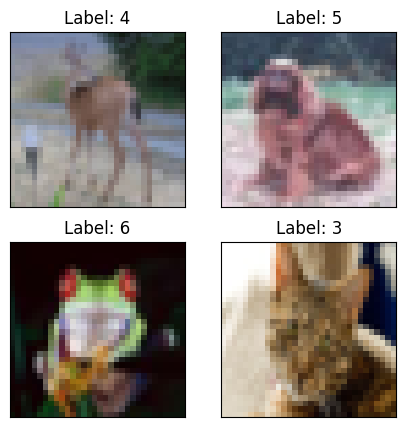

In [ ]:
# PLotting Clean images 
plot_images(
    images=test_images_original[100:200], 
    labels=test_labels_original[100:200],
    plot_label="Label",
    is_categorical=True,
    nrows=2,
    ncols=2,
    figsize=(5, 5))

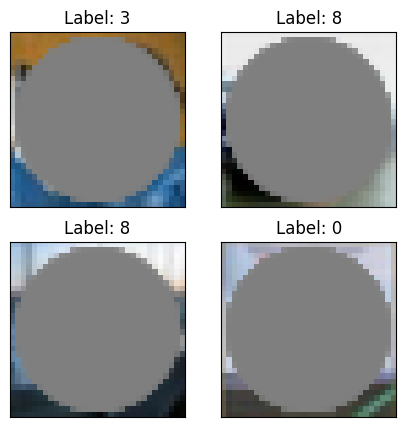

In [ ]:
# PLotting Adversarial images 
plot_images(
    images=adversarial_instances, 
    labels=test_labels_original[:100],
    plot_label="Label",
    is_categorical=True,
    nrows=2,
    ncols=2,
    figsize=(5, 5))

The images indicate these patches created are too inconspicious when used on MNIST and CIFER10